In [123]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/AN2DL/Homework2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/AN2DL/Homework2


In [124]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [125]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [126]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [127]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(training_data)

[[0.         0.         0.         ... 0.60277778 0.36759259 0.33148148]
 [0.         0.         0.         ... 0.6        0.46       0.396     ]
 [0.         0.         0.         ... 0.96048126 0.94650625 0.97714021]
 ...
 [0.         0.         0.         ... 0.52631579 0.58223684 0.55263158]
 [0.         0.         0.         ... 0.44559585 0.58549223 0.40414508]
 [0.         0.         0.         ... 0.54268293 0.6097561  0.59146341]]


In [128]:
training_data.shape

(48000, 2776)

In [129]:
def print_sequence(dataset, to_plot):
  figs, axs = plt.subplots(to_plot, 1, sharex=True, figsize=(17,17))
  n_elements = len(dataset)
  for i in range(to_plot):
    el = random.randrange(n_elements)
    axs[i].plot(dataset[el])
    axs[i].set_title(el)
  plt.show()

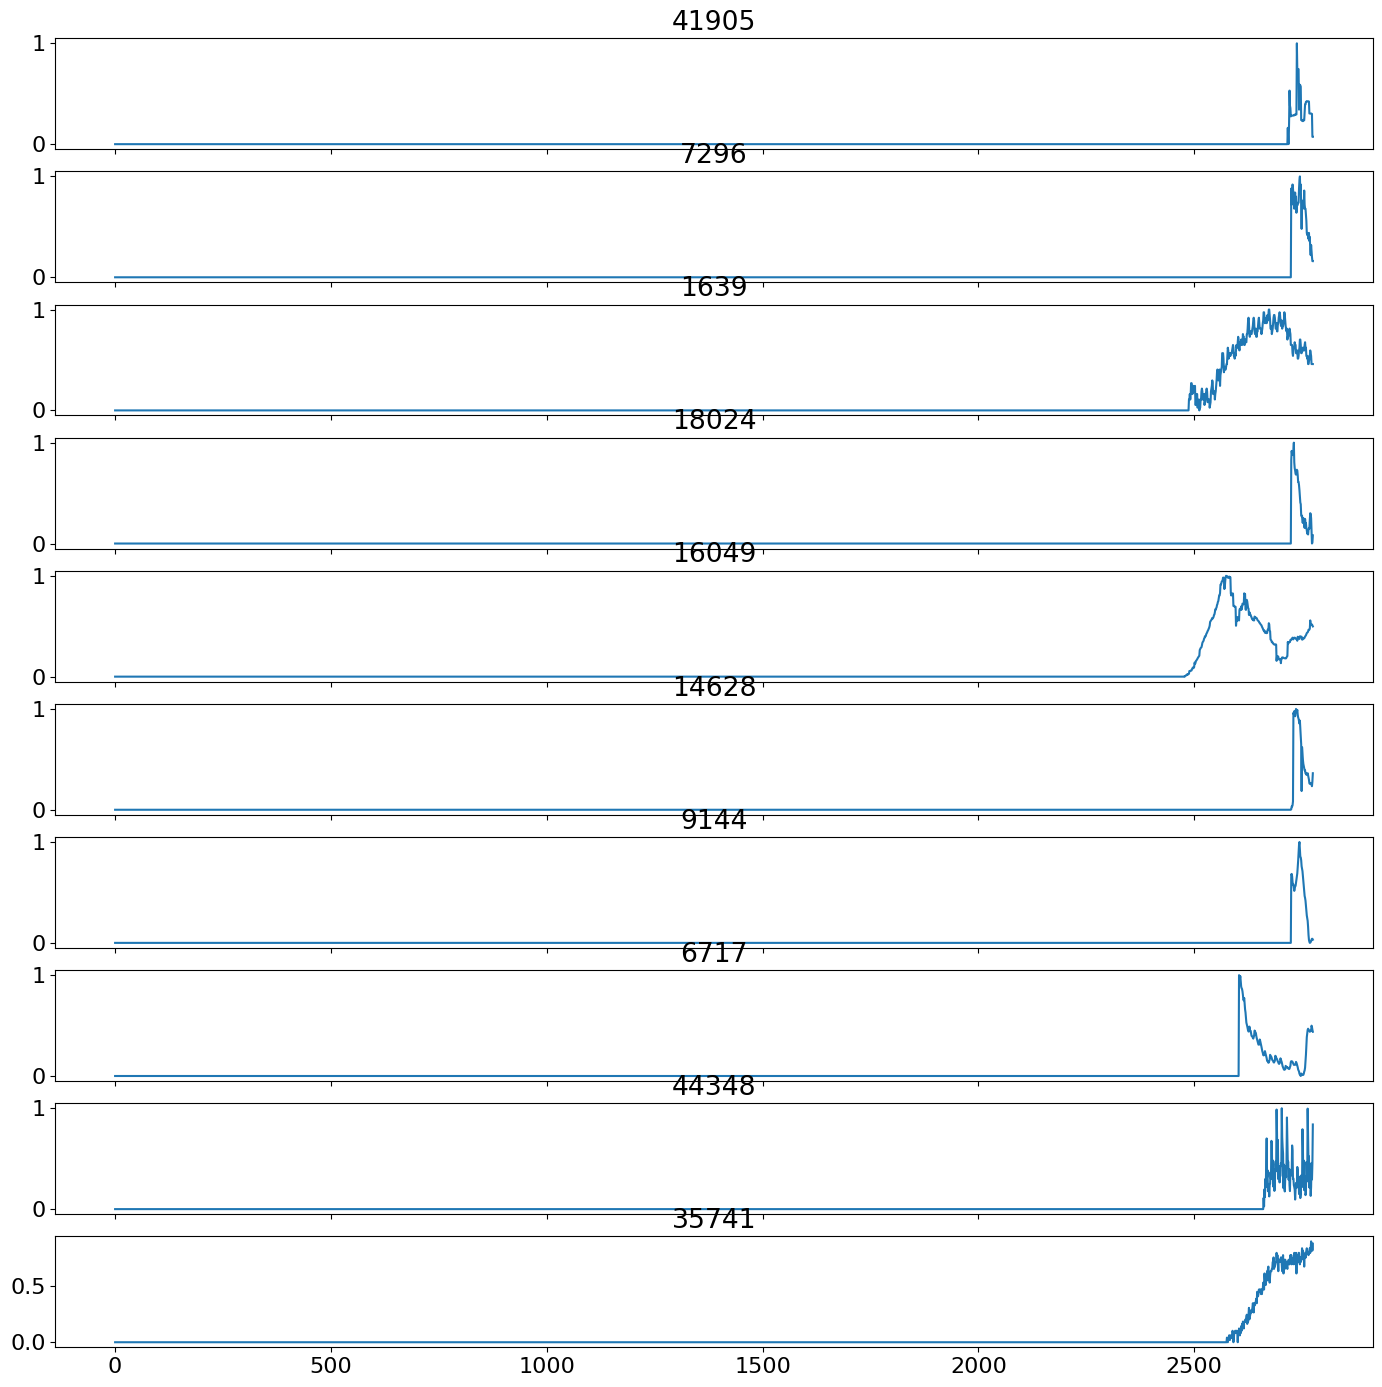

In [130]:
print_sequence(training_data, 10)

In [131]:
dataset = training_data

In [132]:
categories = np.load("categories.npy", allow_pickle=True)
valid_periods = np.load("valid_periods.npy", allow_pickle=True)
categories_Set = set(categories)

dataset = []
for i in range(training_data.shape[0]):
    start = valid_periods[i][0]
    ending = valid_periods[i][1]
    #if ending - start < 218:
    #  start = ending -218
    if(categories[i] == "A"):
      if ending - start > 218:
        dataset.append(training_data[i][start : ending])


In [133]:
print(len(dataset))

3830


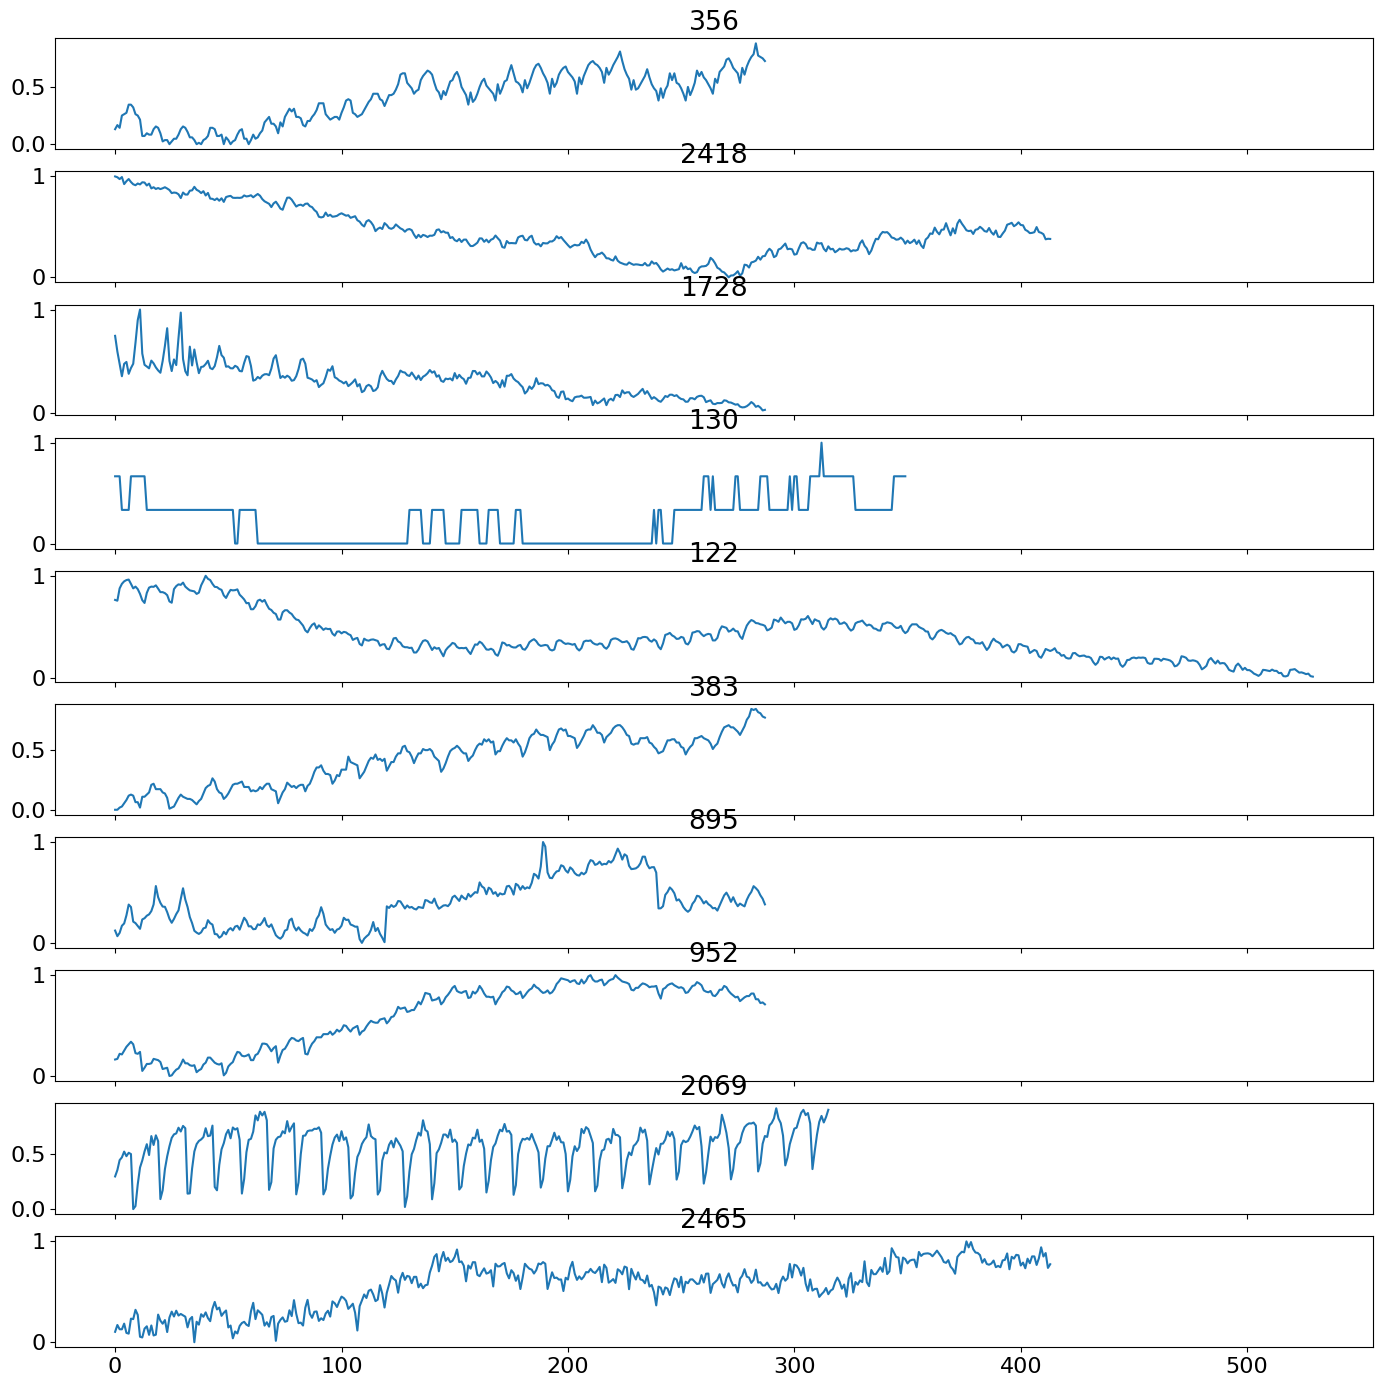

In [134]:
print_sequence(dataset, 10)

In [135]:
def split_train_test(dataset, percentage):
  X_train = []
  X_test = []
  for i in range(len(dataset)):
    pos = int(len(dataset[i])* percentage)
    train_el = dataset[i][:pos]
    test_el = dataset[i][pos:]
    X_train.append(train_el)
    X_test.append(test_el)
  return X_train, X_test

In [136]:
from sklearn.model_selection import train_test_split

In [137]:
def build_sequences(df, window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for el in range(len(df)):
      element = df[el]
      lenght = len(element)
      starting = 0
      ending_w = starting + window
      ending_t = ending_w + telescope
      while True:
        if ending_t > lenght:
          break
        dataset.append(element[starting:ending_w])
        labels.append(element[ending_w:ending_t])
        starting = starting + stride
        ending_w = starting + window
        ending_t = ending_w + telescope

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [138]:
window = 200
stride = 200
telescope = 3
X, y = build_sequences(dataset, window, stride, telescope)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [139]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3946, 200)
(3946, 3)
(987, 200)
(987, 3)


In [140]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train,axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [141]:
input_shape = X_train.shape
output_shape = y_train.shape
batch_size = 64
epochs = 200

In [142]:
print(input_shape)
print(output_shape)

print(input_shape[0] >= output_shape[0])

(3946, 200, 1)
(3946, 3, 1)
True


In [143]:
def seq2seq_LSTM(input_shape, output_shape):
    n_hidden = 100

    input_train = tfkl.Input(shape=(input_shape[1], input_shape[2]))
    output_train = tfkl.Input(shape=(output_shape[1], output_shape[2]))

    encoder_last_h1, encoder_last_h2, encoder_last_c = tfkl.LSTM(
          n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
          return_sequences=False, return_state=True)(input_train)

    encoder_last_h1 = tfkl.BatchNormalization(momentum=0.6)(encoder_last_h1)
    encoder_last_c = tfkl.BatchNormalization(momentum=0.6)(encoder_last_c)

    decoder = tfkl.RepeatVector(output_train.shape[1])(encoder_last_h1)
    decoder = tfkl.LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])

    out = tfkl.TimeDistributed(tfkl.Dense(output_train.shape[2]))(decoder)

    model = tf.keras.Model(inputs=input_train, outputs=out)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1))




    return model

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 lstm_14 (LSTM)              [(None, 100),                40800     ['input_15[0][0]']            
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 batch_normalization_14 (Ba  (None, 100)                  400       ['lstm_14[0][0]']             
 tchNormalization)                                                                          

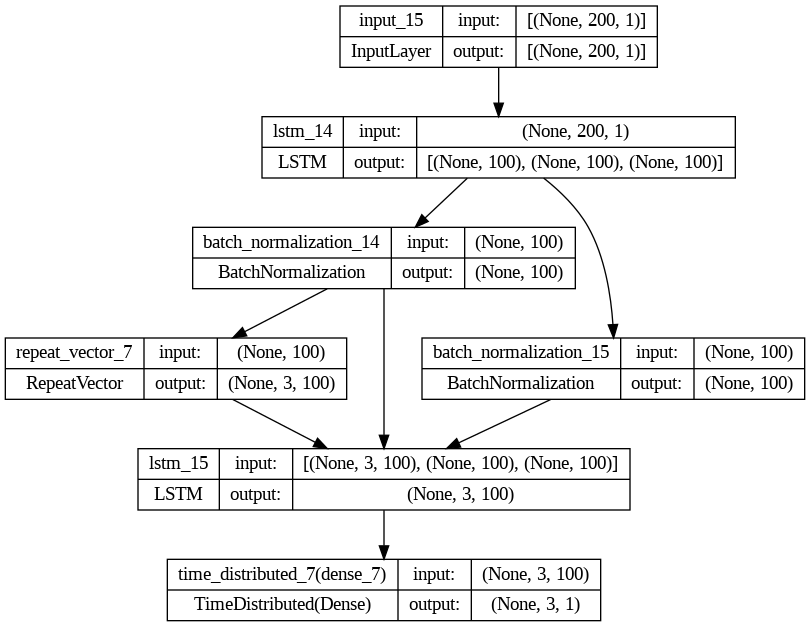

In [144]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [145]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=14, restore_best_weights=True, min_delta=0.00005),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.5, min_lr=1e-7)
    ]
).history

Epoch 1/200
56/56 [==============================] - 49s 752ms/step - loss: 0.2267 - val_loss: 0.0089 - lr: 0.0100
Epoch 2/200
56/56 [==============================] - 41s 741ms/step - loss: 0.0116 - val_loss: 0.0104 - lr: 0.0100
Epoch 3/200
56/56 [==============================] - 40s 714ms/step - loss: 0.0112 - val_loss: 0.0107 - lr: 0.0100
Epoch 4/200
56/56 [==============================] - 43s 750ms/step - loss: 0.0118 - val_loss: 0.0092 - lr: 0.0100
Epoch 5/200
56/56 [==============================] - 44s 787ms/step - loss: 0.0117 - val_loss: 0.0120 - lr: 0.0100
Epoch 6/200
56/56 [==============================] - 45s 799ms/step - loss: 0.0112 - val_loss: 0.0092 - lr: 0.0100
Epoch 7/200
56/56 [==============================] - 44s 770ms/step - loss: 0.0105 - val_loss: 0.0098 - lr: 0.0100
Epoch 8/200
56/56 [==============================] - 42s 752ms/step - loss: 0.0111 - val_loss: 0.0105 - lr: 0.0100
Epoch 9/200
56/56 [==============================] - 42s 758ms/step - loss: 0.01

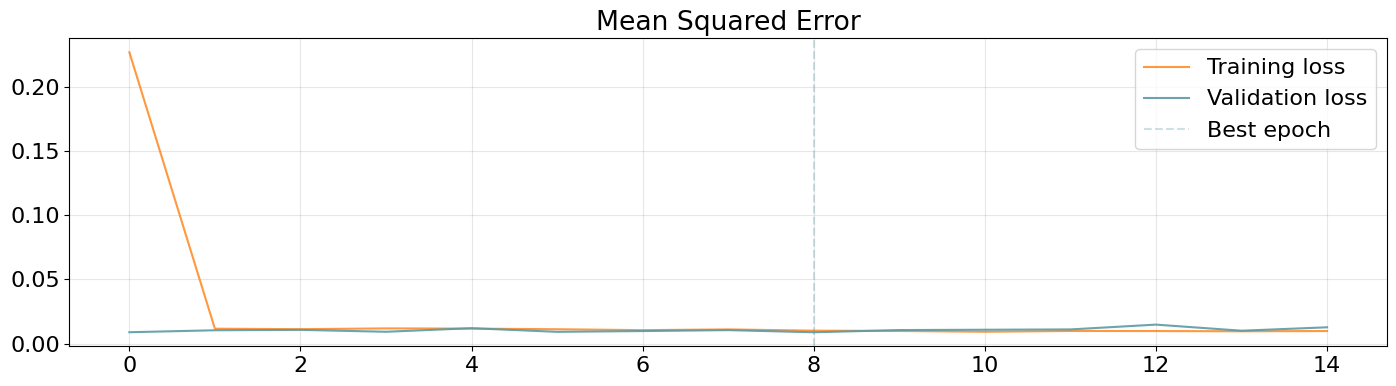

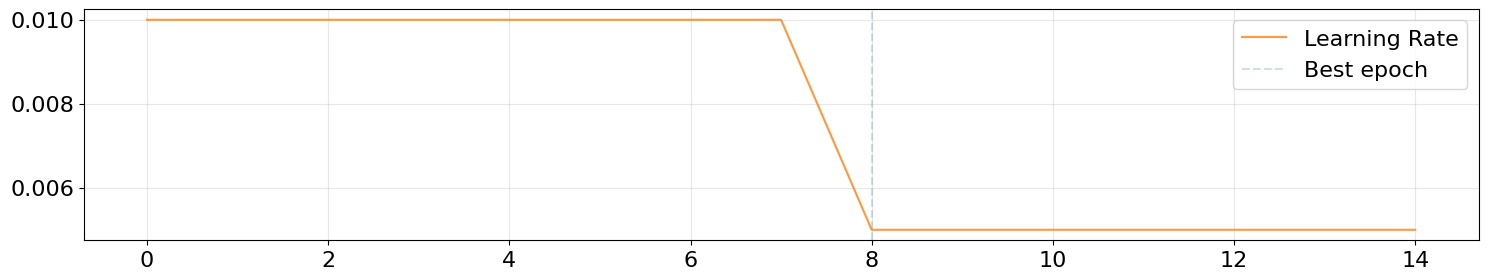

In [146]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [147]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (987, 3, 1)
Mean Squared Error: 0.009356450289487839
Mean Absolute Error: 0.06904564797878265


In [148]:
 # model.save('BidirectionalLSTM')